![Logo](https://res.cloudinary.com/dj8hjwv7j/image/upload/c_scale,w_555/v1710746369/Screen_Shot_2022-04-14_at_5.15.19_PM_cvxm4b.jpg)
## Case 1: Lyft off at Toledo Airport
### By: Marc Torchio

***

## Problem Statement & Assumptions 

**Problem Statement**

* Lyft is looking to maximize profit in **Toledo, OH** for the Airport <--> Downtown route over the next 12 months
    * The main lever to maximizing profit will be Lyft's *take* aka net profit from Driver revenue - currently set at: **$6 / 24%**
    * We assume price of this route will remain constant at $25
    * Changes in Lyft's take will have a direct impact on:
        1. Match Rates
        2. *Rider* Churn Rates
        3. Monthly cost of *rider* and to some extenst *driver* aquisiton 


**Asummptions Local to Case** 

* Driver CAC: $400 - $600
* Driver Avg Rides/month: 100 
* Driver Churn per month: 5%
* Rider CAC: $10 - $20
* Rider Avg Rides/month: 1
* Match Rate when Take == $6: 60%
* Match Rates when Take == $3: 93%
* Rider Churn per month (W/O FTFD* event): 10%
* Rider Churn per month (W/ FTFD* event): 33%


**FTFD: Failed to Find Driver*


*For the purpose of this case, we are assuming the market size and share of Toledo's Airport <--> Downtown rides will not vary signficantly over the course of the next 12 months.  What **will** vary will be the associated costs for aquisition of riders and drivers due to the differing match rates and churn levels due to changes in Lyft's take and as a result rides supplied.*

To fully model out the relationship between changes in Lyft's take and Lyft's revenue and profit, we will use the following framework:

![Lyft's Toledo Pricing Model](https://res.cloudinary.com/dj8hjwv7j/image/upload/c_scale,w_1500/v1710747330/Lyft_s_Business_Model_Elements_6_yuwx3o.png)


Toledo Airport Route for context:

![Toledo Airport Route](https://res.cloudinary.com/dj8hjwv7j/image/upload/v1710367837/Picture1_utvoxi.png)



***

## Calculating Quantity demanded of Rides Per Month - *given 0 churn* 

* A top-down market sizing approach will be used with assumptions pulling from local and national statsistics as well as assumed knowledge of trends
* Sources are provided below.

![Market Sizing Funnel](https://res.cloudinary.com/dj8hjwv7j/image/upload/c_scale,q_97,w_465/v1710382063/Picture3_vmgzzy.png)

*As stated in the case, "Each rider requests 1 ride/ month on average", thus we will assume each of the ~585 monthly Lyft rides to and from Toledo airport are unqiue riders.*

Since churn is a function of matched rides, demand will deviate from this forecast depending on the previous months' churned riders

External Sources:
* [Toledo Express Airports Passenger Traffic Segmentation](https://www.toledoexpress.com/airport-business/advertise-at-tol/)
* [Population of Toledo, OH](https://www.point2homes.com/US/Neighborhood/OH/Toledo/Downtown-Toledo-Demographics.html)
* [Percent of Travelers who Use ride-share](https://airportimprovement.com/news/while-majority-americans-prefer-their-personal-vehicles-travel-and-airports-use-ride-sharing-services-rapidly-accelerating)
* [Lyft Marketshare in the US](https://secondmeasure.com/datapoints/rideshare-industry-overview/)



In [762]:

# Importing necessary packages/libraries and setting a seed(585)
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
np.random.seed(585)
import warnings
warnings.filterwarnings('ignore')

In [763]:
monthly_travelers = 16000
# Business : Lesisure Ratio
b_travel = .1
l_travel = .9

# Percent with toledo as destination/pickup
b_toledo = .8
l_toledo = .25

# Ride-share usage rates
b_rideshare = .7
l_rideshare = .4

# Lyft's market share 
lyft_marketshare = .25

# According to Toledo's Advertising deck, 90% of TOL monthly passengers travel for leiser, while 10% travel for business.
# We will explore some common-sense assumptions about the difference in travel behvior between these two segments.

b_travlers = (b_travel * monthly_travelers) * b_toledo * b_rideshare * lyft_marketshare
l_travlers = l_travel * monthly_travelers  * l_toledo * l_rideshare * lyft_marketshare

total_rides_per_month = b_travlers + l_travlers
print(f'The average monthly amount of lyft rides demanded at a price of $25 for the Toledo Airport <--> Toledo Downtown route is {int(total_rides_per_month)} rides or {round((total_rides_per_month / monthly_travelers) * 100)}% of Toledo\'s total airport traffic (16,000).')

The average monthly amount of lyft rides demanded at a price of $25 for the Toledo Airport <--> Toledo Downtown route is 584 rides or 4% of Toledo's total airport traffic (16,000).


***

## Initializing Variables
* **Demand Side Variables (Riders)**
   1. Rides demanded -- set through top down market sizing estimation
   2. Rides matched -- rides demanded * match rate
   3. Riders churned -- determined as a function of un-matched rides --> *also to be considered: amount of riders needed to be aquired in the following month*
   4. Rider CAC -- to adjust for pentration rate aka count of newly aquired riders YTD
   5. Total incurred rider CAC -- Rider churned in previous month * Rider CAC

* **Supply Side Variables (Drivers)**
   1. *Willing* rides supplied -- equivalent to the match rate * rides requested / rides matched
   2. Number of drivers -- determined as a function of willing rides supplied
   3. Drivers churned -- as a function of Lyft's take/Driver Revenue --> *also to be considered: amount of riders needed to be aquired in the following month*
   4. Driver CAC -- to adjust for the penetration rate aka count of newly aquired drivers YTD
   5. Total incurred rider CAC -- Driver churned in previous month * Driver CAC

* **Objective** 
  * Net Revenue -- (Lyft's take * Rides matched)
  * Profit -- (net revenue - (total incurred rider CAC + total incurred driver CAC))

In [764]:

# Initalizing dataframe df with months and predicted rides requested (quantity demanded) 
def rides_demanded_df():
    data = []  # List to accumulate data
    months = ['PDec','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    

    # Iteratring through all months to introduce seasonality factors and randomness into the forecasted rides demanded
    std = 0.0175 * total_rides_per_month  # Assuming a population standard deviation of (1.75% * total_rides_per_month)  Rides
    for month in months:
        num_rides = round(np.random.normal(total_rides_per_month, scale=std))
        if month in ['PDec','Mar', 'Dec','Nov']: # Incorpoating seasonality increase in avg travel of 8% for holidays months
            num_rides = num_rides * 1.08
        elif month in ['Jun', 'Jul', 'Aug']: # Incorpoating seasonality increase in avg travel of 5% for Summer months
            num_rides = num_rides * 1.025
        else:
            num_rides = num_rides * .95
        data.append({'Month': month, 'Number_of_rides': round(num_rides)})
    
    df = pd.DataFrame(data)  # Construct DataFrame from accumulated data
    df.loc[1,'pm_rides'] = 0
    df.loc[2:,'pm_rides'] = df['Number_of_rides'].shift(1).fillna(0)
    return df


# Initializing base df
df = rides_demanded_df()


In [765]:
# Creating a list of all possible values for Lyft's Take ranging from $2.00 to $10.00
lyfts_take = [i/10 for i in range(20,101, 1)]

# Function to create key value pairs between every take value and its associated match rate
def match_rate(lyfts_take):
    points = np.array([[6, .6], [3, 0.93]])  # Given points from pricing experiment
    m, b = np.polyfit(points[:, 0], points[:, 1], 1)
    # Using dictionary comprehension and vectorized operations
    return {take: round((take * m) + b, 2) for take in lyfts_take}

# Creating a list of key values pairs for lyft's take and its assoicated match rate based off the pricing experiment 
take_and_match = match_rate(lyfts_take)


In [766]:

# Calculating the previous month's churned riders as a function of quantity rides demanded in the previous month and the match rate
def pm_churned_riders(demand, match_rate, norm_churn_rate=.1, FTFD_churn_rate=.33):
    FTFD_rate = 1 - match_rate
    # Logic to calculate churn based on provided formulas
    churned_base = (demand * FTFD_rate) * FTFD_churn_rate + (demand * match_rate) * norm_churn_rate
    return churned_base


# Calculating Rider Aquisition cost as a function of YTD aquistion and a starting rider CAC = $10 
def adjusted_rider_CAC(row, rider_CAC = 10):
    if ((row['YTD_rider_churn'] * .0035) + rider_CAC)> 20:
        return 20
    else:
        sensitivity_adjustment = (row['YTD_rider_churn'] * .0035) 
        new_CAC = sensitivity_adjustment + rider_CAC
        return new_CAC


# Calculating monthly drivers as a function of quantity rides demanded and the match rate
def monthly_drivers(Matched_rides, match_rate):
    airport_drivers = (Matched_rides / 4) / 3 # Calculating the number of unqiue Lyft drivers who on average complete 3 airport rides a week i.e. airport trips make up about ~12% of their total monthly average of completed trips (100)
    return airport_drivers


# Calculating the previous month's driver churn as a function of the driver churn rate and the previous month's airport driver count 
def PM_churned_drivers(pm_monthly_drivers, lyft_take, churn_rate = .05):
    adjusted_churn_rate = churn_rate + ((lyft_take - 6) * .0065) # Variance as a function of Lyft's take is incorporated into the given driver churn rate of 5%. Function assumes Lyft's take will not exceed $10 
    return round(adjusted_churn_rate * pm_monthly_drivers)


# Calculating driver aquistion cost as a function of YTD acquistion and a starting driver CAC = $400
def adjusted_driver_CAC(row, driver_cac = 400):
    if ((row['YTD_driver_churn'] * 3.5) + driver_CAC)> 600: 
        return 600
    else:
        sensitivity_adjustment = (row['YTD_driver_churn'] * 3.5)  # a 3.5 senstivity is an arbitrary number that insures driver CAC fluctuates in relation to the acquistion rate but increases within the range provided (400 - 600)
        new_CAC = sensitivity_adjustment + driver_CAC
        return new_CAC

***

## Running the model
### Optimizing for Profit at the end of 12 months

In [902]:
# Running all functions to establish a comprehensive dataframe df
def create_df(df, match_rate, take):

    # Calculating adjusted riders demanded 
    df['pm_churned_riders'] = round(pm_churned_riders(df['pm_rides'],match_rate))
    df['Adjusted_rides_demanded'] = round(df['Number_of_rides'] - (df['pm_churned_riders']*.25))

    # Calculating rider side variables 
    df['YTD_rider_churn'] = df['pm_churned_riders'].cumsum()
    df['Adjusted_rider_CAC'] = df.apply(adjusted_rider_CAC,axis=1)
    df['Monthly_Rider_CAC'] = round((df['Adjusted_rider_CAC'] * (df['pm_churned_riders']*.75)),2) 

    # Supply Variables:
    df['Matched_rides'] = round(df['Adjusted_rides_demanded'] * match_rate)
    df['Monthly_drivers'] = df['Matched_rides'].apply(monthly_drivers, args = (match_rate,))
    df['pm_monthly_drivers'] = df['Monthly_drivers'].shift(1).fillna(0)
    df['pm_churned_drivers'] = df['pm_monthly_drivers'].apply(PM_churned_drivers, args=(take,))
    df['YTD_driver_churn'] = df['pm_churned_drivers'].cumsum()
    df['Adjusted_driver_CAC'] = df.apply(adjusted_driver_CAC,axis=1)
    df['Monthly_Driver_CAC'] = round((df['Adjusted_driver_CAC'] * df['pm_churned_drivers']),2)

    # Objective variables
    df['Net_Revenue'] = round(take * df['Matched_rides'],2)
    df['Profit'] = round(df['Net_Revenue'] - (df['Monthly_Driver_CAC'] + df['Monthly_Rider_CAC']),2)
        
    return df[1:] # Returning the df without the previous year's december month

# Running main function to optimzie for net revenue / profit 
def optimize_revenue(df):
    
    Net_Revenue = 0
    Profit = 0
    optimized_take = 0
    optimized_match_rate = 0
    
    for take, match_rate in take_and_match.items():
        initial_df = create_df(df, match_rate, take)
        
        if initial_df['Profit'].sum() > Profit:
            Net_Revenue = initial_df['Net_Revenue'].sum()
            Profit = initial_df['Profit'].sum()
            optimized_take = take
            optimized_match_rate = match_rate 
            final_df = initial_df
        
        else:
            continue

    return final_df, round(Net_revenue), round(Profit), optimized_take, optimized_match_rate

final_df, Net_revenue, Profit, optimized_take, optimized_match_rate = optimize_revenue(df)


print(f'The model found the optimal take for each ride to be ${optimized_take} with a match rate of {optimized_match_rate*100}%.  This results in a net revenue of ${Net_revenue} and a profit of ${Profit} at the end of the 12 months.')
final_df

The model found the optimal take for each ride to be $4.5 with a match rate of 77.0%.  This results in a net revenue of $20944 and a profit of $9193 at the end of the 12 months.


,Month,Number_of_rides,pm_rides,Adjusted_rides_demanded,pm_churned_riders,YTD_rider_churn,Adjusted_rider_CAC,Monthly_Rider_CAC,Matched_rides,Monthly_drivers,pm_monthly_drivers,pm_churned_drivers,YTD_driver_churn,Adjusted_driver_CAC,Monthly_Driver_CAC,Net_Revenue,Profit
1,Jan,542,0.0,542.0,0.0,0.0,10.0000,0.00,417.0,34.750000,0.000000,0,0,400.0,0.0,1876.5,1876.50
2,Feb,556,542.0,535.0,83.0,83.0,10.2905,640.58,412.0,34.333333,34.750000,1,1,403.5,403.5,1854.0,809.92
3,Mar,639,556.0,618.0,85.0,168.0,10.5880,674.98,476.0,39.666667,34.333333,1,2,407.0,407.0,2142.0,1060.02
4,Apr,558,639.0,534.0,98.0,266.0,10.9310,803.43,411.0,34.250000,39.666667,2,4,414.0,828.0,1849.5,218.07
5,May,543,558.0,522.0,85.0,351.0,11.2285,715.82,402.0,33.500000,34.250000,1,5,417.5,417.5,1809.0,675.68
6,Jun,593,543.0,572.0,83.0,434.0,11.5190,717.06,440.0,36.666667,33.500000,1,6,421.0,421.0,1980.0,841.94
7,Jul,603,593.0,580.0,91.0,525.0,11.8375,807.91,447.0,37.250000,36.666667,1,7,424.5,424.5,2011.5,779.09
8,Aug,594,603.0,571.0,92.0,617.0,12.1595,839.01,440.0,36.666667,37.250000,1,8,428.0,428.0,1980.0,712.99
9,Sep,549,594.0,526.0,91.0,708.0,12.4780,851.62,405.0,33.750000,36.666667,1,9,431.5,431.5,1822.5,539.38
10,Oct,560,549.0,539.0,84.0,792.0,12.7720,804.64,415.0,34.583333,33.750000,1,10,435.0,435.0,1867.5,627.86


***

## Supporting Visualizations
* Forecasted rides demanded accross time
* Match rate and Take's relationship
* Four Options Modeled

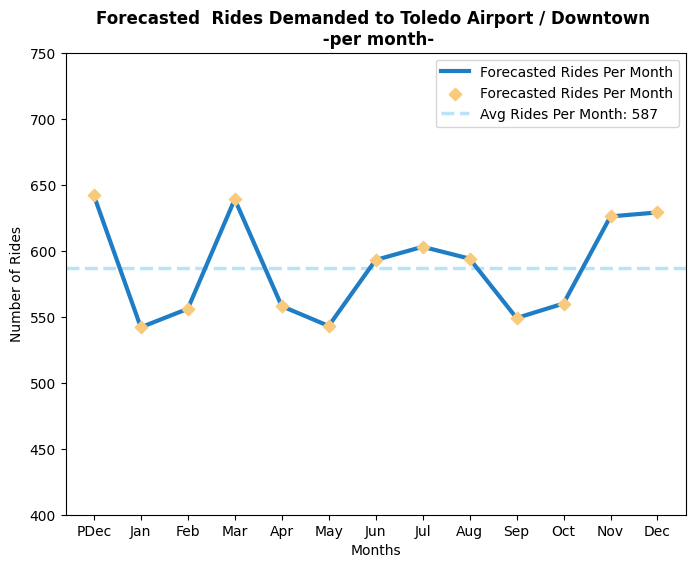

In [899]:
fig, axs = plt.subplots(figsize=(8, 6))

# Plotting Number of rides against Months in the year
ax = plt.subplot()
plt.plot(df.Month, df.Number_of_rides, label = "Forecasted Rides Per Month",color='#1e7dc5',linewidth = 3,zorder=2)
plt.scatter(df.Month, df.Number_of_rides, label = "Forecasted Rides Per Month",color='#f9ca7b',zorder=2,marker='D',s=40)
ax.set_yticks([i for i in range(400,800,50)])
avg_rides = df.Number_of_rides.mean()
plt.axhline(y=avg_rides, color='#b9e3f7', linestyle='--',linewidth = 2.5, label= f'Avg Rides Per Month: {round(avg_rides)}',zorder=1)

# Etablishing legend, titles, and labels 
plt.legend()
plt.title('Forecasted  Rides Demanded to Toledo Airport / Downtown \n -per month-', weight = 'bold')

plt.xlabel('Months')
plt.ylabel('Number of Rides')
plt.savefig('Forecasted_Demand.png', transparent=True)
plt.show()


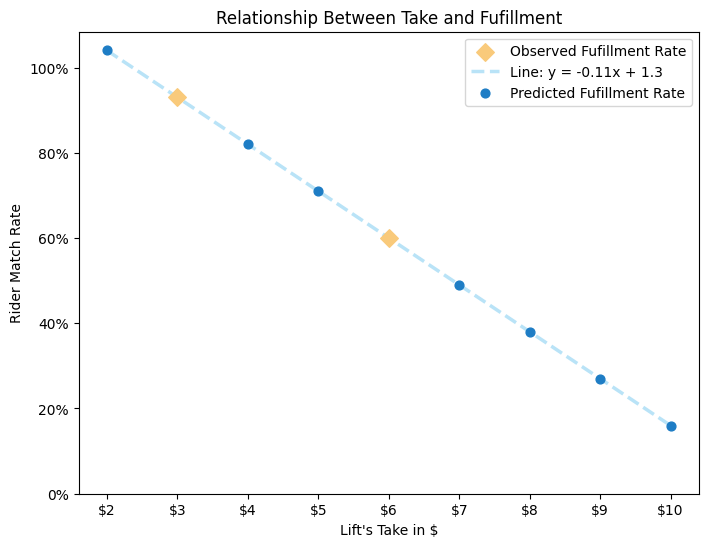

The Regression Equation for this line is y = -0.11x + 1.3


In [898]:
fig, axs = plt.subplots(figsize=(8, 6))

# Given points
points = np.array([[6,.6], [3,0.93]])

# Generate x values
x_vals = [i for i in range(2, 11, 1)]
x_vals.pop(1)
x_vals.pop(3)

# Initialize list for predicted points
predicted_points = []

# Solve for linear regression line
m, b = np.polyfit(points[:, 0],points[:, 1], 1)

# Calculate predicted points
for i in x_vals:
    y_val = round((i * m) + b , 2)
    predicted_points.append([i, y_val])

# Extract x and y coordinates separately
predicted_x = [point[0] for point in predicted_points]
predicted_y = [point[1] for point in predicted_points]
# Plotting the points
plt.scatter(points[:, 0], points[:, 1], color='#f9ca7b', marker='D', s=80, label='Observed Fufillment Rate',zorder = 2)

# Plot the predicted points
plt.plot(predicted_x, predicted_y, color='#b9e3f7', linestyle='--', linewidth=2.5,label= f'Line: y = {round(m,2)}x + {round(b,1)} ', zorder = 1)

plt.scatter(predicted_x, predicted_y, color='#1e7dc5', marker='o',s=40, label='Predicted Fufillment Rate', zorder = 2)
# Labeling the plot 
ax = plt.subplot()
plt.xlabel("Lift's Take in $")
plt.ylabel("Rider Match Rate")
plt.title('Relationship Between Take and Fufillment')
plt.legend()


ax.set_yticks([i / 100 for i in range(0,120,20)])
ax.set_yticklabels([str(i) + '%' for i in range(0,120,20)])
ax.set_xticks([i for i in range(2,11,1)])
ax.set_xticklabels(['$' + str(i) for i in range(2,11,1)])

# Show plot
plt.savefig('Regression.png', transparent=True)
plt.show()

print(f'The Regression Equation for this line is y = {round(m,2)}x + {round(b,1)}')

In [873]:

def viz_options(base_df, match, take):
    temp_df = create_df(base_df, match, take)
    temp_df['total_costs'] = (temp_df['Monthly_Driver_CAC']) + (temp_df['Monthly_Rider_CAC'])
    temp_df['total_costs_YTD'] = temp_df['total_costs'].cumsum()
    temp_df['Net_Revenue_YTD'] = temp_df['Net_Revenue'].cumsum()
    temp_df['Profit_YTD'] = temp_df['Profit'].cumsum()
    return temp_df[['Month','Adjusted_rides_demanded','Net_Revenue_YTD','total_costs_YTD','Profit_YTD']]


In [879]:
opt_1 = viz_options(df, m_and_t[2], 2)
opt_2 = viz_options(df,m_and_t[4.5],4.5)
opt_3 = viz_options(df,m_and_t[6],6)
opt_4 = viz_options(df,m_and_t[8],8)

In [900]:
opt_2

,Month,Adjusted_rides_demanded,Net_Revenue_YTD,total_costs_YTD,Profit_YTD
1,Jan,542.0,1876.5,0.00,1876.50
2,Feb,535.0,3730.5,1044.08,2686.42
3,Mar,618.0,5872.5,2126.06,3746.44
4,Apr,534.0,7722.0,3757.49,3964.51
5,May,522.0,9531.0,4890.81,4640.19
6,Jun,572.0,11511.0,6028.87,5482.13
7,Jul,580.0,13522.5,7261.28,6261.22
8,Aug,571.0,15502.5,8528.29,6974.21
9,Sep,526.0,17325.0,9811.41,7513.59
10,Oct,539.0,19192.5,11051.05,8141.45


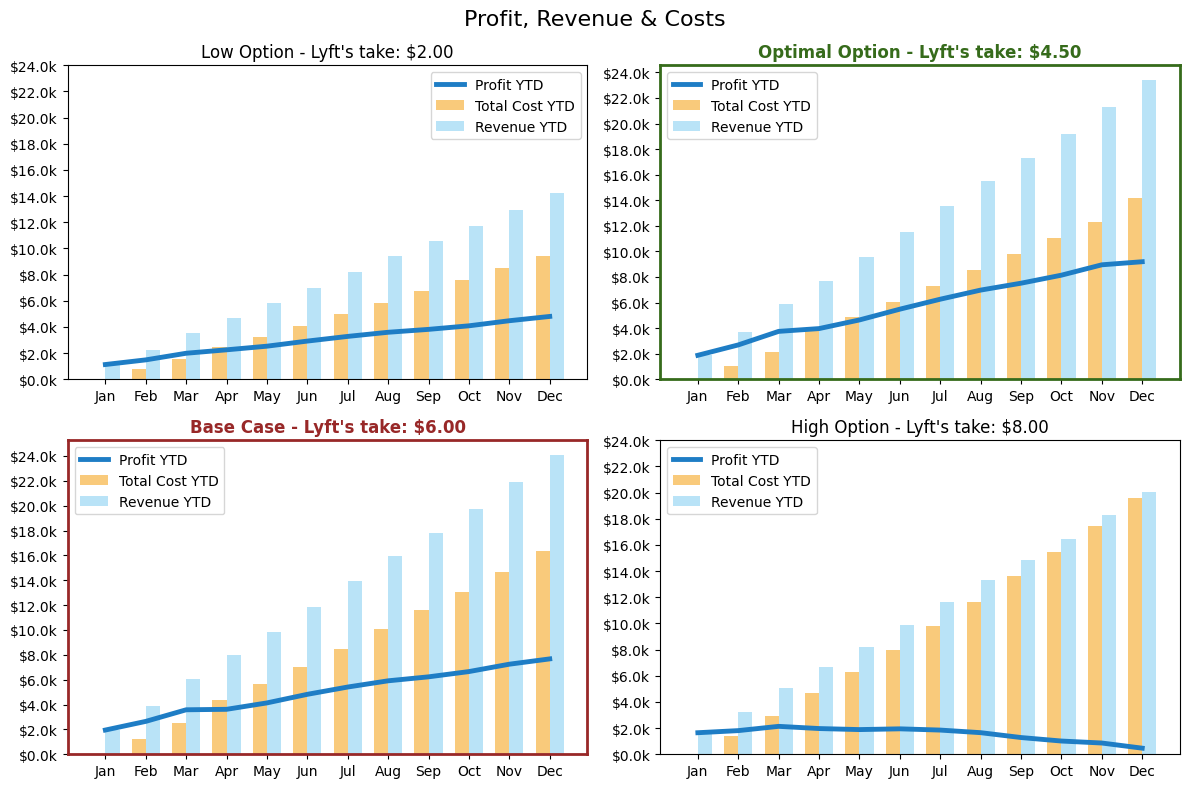

In [897]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
months = np.arange(len(opt_1['Month']))  # Assuming Month is in a format that can be turned into a range
width = 0.35  # the width of the bars

# Option 1 Plot

# Plotting the first set of bars for Total Cost YTD
bars1 = axs[0, 0].bar(months - width/2, opt_1['total_costs_YTD'], width, label='Total Cost YTD', color='#f9ca7b')

# Plotting the second set of bars for Net Revenue YTD
bars2 = axs[0, 0].bar(months + width/2, opt_1['Net_Revenue_YTD'], width, label='Revenue YTD',color = '#b9e3f7')

# Plotting a line chart for Profit YTD with green color and thicker line
axs[0, 0].plot(months, opt_1['Profit_YTD'], color='#1e7dc5', linewidth=3.5, label='Profit YTD')

# Adding some customizations
axs[0, 0].set_title("Low Option - Lyft's take: $2.00")
axs[0, 0].set_xticks(months)
axs[0, 0].set_xticklabels(opt_1['Month'])
axs[0, 0].set_yticks([i for i in range(0,26000,2000)])
axs[0, 0].set_yticklabels(['$'+str(i / 1000) + 'k' for i in range(0,26000,2000)])
axs[0, 0].legend()


# Option 2 Plot

# Plotting the first set of bars for Total Cost YTD
bars3 = axs[0, 1].bar(months - width/2, opt_2['total_costs_YTD'], width, label='Total Cost YTD', color='#f9ca7b')

# Plotting the second set of bars for Net Revenue YTD
bars4 = axs[0, 1].bar(months + width/2, opt_2['Net_Revenue_YTD'], width, label='Revenue YTD',color = '#b9e3f7')

# Plotting a line chart for Profit YTD with green color and thicker line
axs[0, 1].plot(months, opt_2['Profit_YTD'], color='#1e7dc5', linewidth=3.5, label='Profit YTD')

# Adding some customizations
axs[0, 1].spines['top'].set_color('#366B1B')  
axs[0, 1].spines['top'].set_linewidth(2)  
axs[0, 1].spines['bottom'].set_color('#366B1B')  
axs[0, 1].spines['bottom'].set_linewidth(2)  
axs[0, 1].spines['left'].set_color('#366B1B')  
axs[0, 1].spines['left'].set_linewidth(2)  
axs[0, 1].spines['right'].set_color('#366B1B')  
axs[0, 1].spines['right'].set_linewidth(2)  

axs[0, 1].set_title("Optimal Option - Lyft's take: $4.50",weight='bold', color='#366B1B')
axs[0, 1].set_xticks(months)
axs[0, 1].set_xticklabels(opt_2['Month'])
axs[0, 1].set_yticks([i for i in range(0,26000,2000)])
axs[0, 1].set_yticklabels(['$'+str(i / 1000) + 'k' for i in range(0,26000,2000)])
axs[0, 1].legend()


# Option 3 Plot

# Plotting the first set of bars for Total Cost YTD
bars5 = axs[1, 0].bar(months - width/2, opt_3['total_costs_YTD'], width, label='Total Cost YTD', color='#f9ca7b')

# Plotting the second set of bars for Net Revenue YTD
bars6 = axs[1, 0].bar(months + width/2, opt_3['Net_Revenue_YTD'], width, label='Revenue YTD',color = '#b9e3f7')

# Plotting a line chart for Profit YTD with green color and thicker line
axs[1, 0].plot(months, opt_3['Profit_YTD'], color='#1e7dc5', linewidth=3.5, label='Profit YTD')

# Adding some customizations
axs[1, 0].spines['top'].set_color('#982828')  
axs[1, 0].spines['top'].set_linewidth(2)  
axs[1, 0].spines['bottom'].set_color('#982828')  
axs[1, 0].spines['bottom'].set_linewidth(2)  
axs[1, 0].spines['left'].set_color('#982828')  
axs[1, 0].spines['left'].set_linewidth(2)  
axs[1, 0].spines['right'].set_color('#982828') 
axs[1, 0].spines['right'].set_linewidth(2)

axs[1, 0].set_title("Base Case - Lyft's take: $6.00", weight='bold',color='#982828')
axs[1, 0].set_xticks(months)
axs[1, 0].set_xticklabels(opt_1['Month'])
axs[1, 0].set_yticks([i for i in range(0,26000,2000)])
axs[1, 0].set_yticklabels(['$'+str(i / 1000) + 'k' for i in range(0,26000,2000)])
axs[1, 0].legend()


# Option 4 Plot

# Plotting the first set of bars for Total Cost YTD
bars7 = axs[1, 1].bar(months - width/2, opt_4['total_costs_YTD'], width, label='Total Cost YTD', color='#f9ca7b')

# Plotting the second set of bars for Net Revenue YTD
bars8 = axs[1, 1].bar(months + width/2, opt_4['Net_Revenue_YTD'], width, label='Revenue YTD',color = '#b9e3f7')

# Plotting a line chart for Profit YTD with green color and thicker line
axs[1, 1].plot(months, opt_4['Profit_YTD'], color='#1e7dc5', linewidth=3.5, label='Profit YTD')

# Adding some customizations
axs[1, 1].set_title("High Option - Lyft's take: $8.00")
axs[1, 1].set_xticks(months)
axs[1, 1].set_xticklabels(opt_4['Month'])
axs[1, 1].set_yticks([i for i in range(0,26000,2000)])
axs[1, 1].set_yticklabels(['$'+ str(i / 1000) + 'k' for i in range(0,26000,2000)])
axs[1, 1].legend()

# Adjust layout

fig.suptitle('Profit, Revenue & Costs', fontsize=16)
plt.subplots_adjust(top=1)
plt.tight_layout()
# Display the plot
plt.savefig('Profit.png', transparent=True)
plt.show()


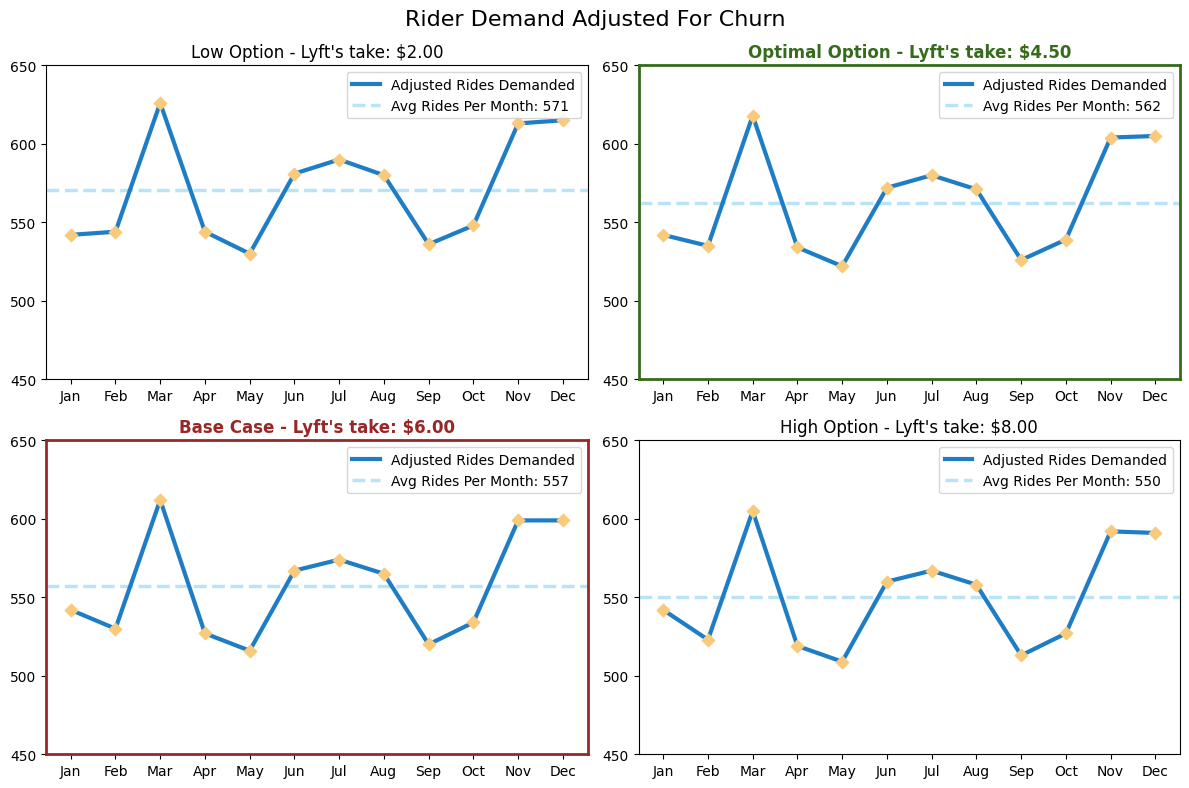

In [895]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
months = np.arange(len(opt_1['Month']))  # Assuming Month is in a format that can be turned into a range
width = 0.35  # the width of the bars

# Option 1 Plot


# Plotting a line chart for Profit YTD with green color and thicker line
axs[0, 0].plot(months, opt_1['Adjusted_rides_demanded'], color='#1e7dc5',linewidth = 3,zorder=2, label='Adjusted Rides Demanded')
axs[0, 0].scatter(months, opt_1['Adjusted_rides_demanded'],color='#f9ca7b',zorder=2,marker='D',s=40)

opt1_avg = opt_1['Adjusted_rides_demanded'].mean()
axs[0, 0].axhline(y=opt1_avg, color='#b9e3f7', linestyle='--',linewidth = 2.5, label= f'Avg Rides Per Month: {round(opt1_avg)}',zorder=1)

# Adding some customizations
axs[0, 0].set_title("Low Option - Lyft's take: $2.00")
axs[0, 0].set_xticks(months)
axs[0, 0].set_xticklabels(opt_1['Month'])
axs[0, 0].set_yticks([i for i in range(450,700,50)])

axs[0, 0].legend()


# Option 2 Plot



# Plotting a line chart for Profit YTD with green color and thicker line
axs[0, 1].plot(months, opt_2['Adjusted_rides_demanded'], color='#1e7dc5',linewidth = 3,zorder=2, label='Adjusted Rides Demanded')
axs[0, 1].scatter(months, opt_2['Adjusted_rides_demanded'],color='#f9ca7b',zorder=2,marker='D',s=40)

opt2_avg = opt_2['Adjusted_rides_demanded'].mean()
axs[0, 1].axhline(y=opt2_avg, color='#b9e3f7', linestyle='--',linewidth = 2.5, label= f'Avg Rides Per Month: {round(opt2_avg)}',zorder=1)

# Adding some customizations
axs[0, 1].spines['top'].set_color('#366B1B')  
axs[0, 1].spines['top'].set_linewidth(2)  
axs[0, 1].spines['bottom'].set_color('#366B1B')  
axs[0, 1].spines['bottom'].set_linewidth(2)  
axs[0, 1].spines['left'].set_color('#366B1B')  
axs[0, 1].spines['left'].set_linewidth(2)  
axs[0, 1].spines['right'].set_color('#366B1B')  
axs[0, 1].spines['right'].set_linewidth(2)  

axs[0, 1].set_title("Optimal Option - Lyft's take: $4.50",weight='bold', color='#366B1B')
axs[0, 1].set_xticks(months)
axs[0, 1].set_xticklabels(opt_2['Month'])
axs[0, 1].set_yticks([i for i in range(450,700,50)])
axs[0, 1].legend()


# Option 3 Plot



# Plotting a line chart for Profit YTD with green color and thicker line
axs[1, 0].plot(months, opt_3['Adjusted_rides_demanded'], color='#1e7dc5',linewidth = 3,zorder=2, label='Adjusted Rides Demanded')
axs[1, 0].scatter(months, opt_3['Adjusted_rides_demanded'],color='#f9ca7b',zorder=2,marker='D',s=40)

opt3_avg = opt_3['Adjusted_rides_demanded'].mean()
axs[1, 0].axhline(y=opt3_avg, color='#b9e3f7', linestyle='--',linewidth = 2.5, label= f'Avg Rides Per Month: {round(opt3_avg)}',zorder=1)

# Adding some customizations
axs[1, 0].spines['top'].set_color('#982828')  
axs[1, 0].spines['top'].set_linewidth(2)  
axs[1, 0].spines['bottom'].set_color('#982828')  
axs[1, 0].spines['bottom'].set_linewidth(2)  
axs[1, 0].spines['left'].set_color('#982828')  
axs[1, 0].spines['left'].set_linewidth(2)  
axs[1, 0].spines['right'].set_color('#982828') 
axs[1, 0].spines['right'].set_linewidth(2)

axs[1, 0].set_title("Base Case - Lyft's take: $6.00", weight='bold',color='#982828')
axs[1, 0].set_xticks(months)
axs[1, 0].set_xticklabels(opt_1['Month'])
axs[1, 0].set_yticks([i for i in range(450,700,50)])
axs[1, 0].legend()


# Option 4 Plot



# Plotting a line chart for Profit YTD with green color and thicker line
axs[1, 1].plot(months, opt_4['Adjusted_rides_demanded'], color='#1e7dc5',linewidth = 3,zorder=2, label='Adjusted Rides Demanded')
axs[1, 1].scatter(months, opt_4['Adjusted_rides_demanded'],color='#f9ca7b',zorder=2,marker='D',s=40)

opt4_avg = opt_4['Adjusted_rides_demanded'].mean()
axs[1, 1].axhline(y=opt4_avg, color='#b9e3f7', linestyle='--',linewidth = 2.5, label= f'Avg Rides Per Month: {round(opt4_avg)}',zorder=1)

# Adding some customizations
axs[1, 1].set_title("High Option - Lyft's take: $8.00")
axs[1, 1].set_xticks(months)
axs[1, 1].set_xticklabels(opt_4['Month'])
axs[1, 1].set_yticks([i for i in range(450,700,50)])
axs[1, 1].legend()

# Adjust layout

fig.suptitle('Rider Demand Adjusted For Churn', fontsize=16)
plt.subplots_adjust(top=1)
plt.tight_layout()
# Display the plot
plt.savefig('Demand_Churn.png', transparent=True)
plt.show()


***